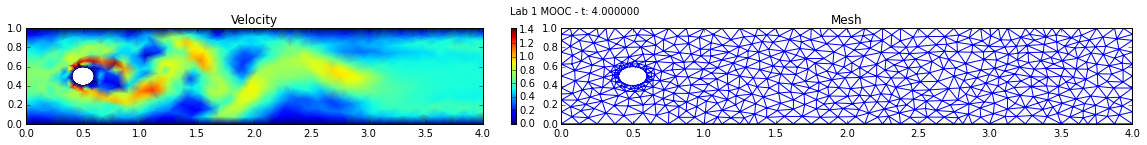

In [ ]:
%matplotlib inline
%run /home/fenics/fenics-matplotlib.py
from dolfin import *; from mshr import *; from IPython.display import display, clear_output; import time
import logging; logging.getLogger('FFC').setLevel(logging.WARNING)

XMIN = 0.; XMAX = 4.; YMIN = 0; YMAX = 1.; G = [XMIN, XMAX, YMIN, YMAX]; eps = 1e-5 # Geometry and mesh

mresolution=30
mesh = generate_mesh(Rectangle(Point(G[0], G[2]), Point(G[1], G[3])) - Circle(Point(.5, .5), .1), mresolution)

# FEM functions
V = VectorFunctionSpace(mesh, "CG", 1); Q = FunctionSpace(mesh, "CG", 1); W = V * Q; h = CellSize(mesh);
(v, q) = TestFunctions(W); w = Function(W); (u, p) = (as_vector((w[0], w[1])), w[2]); u0 = Function(V)

def plot_compact(u, t, stepcounter): # Compact plot utility function
    if stepcounter % 5 == 0:
        uEuclidnorm = project(sqrt(inner(u, u)), Q); ax.cla(); fig = plt.gcf(); fig.set_size_inches(16, 2)
        plt.subplot(1, 2, 1); mplot_function(uEuclidnorm); plt.title("Velocity") # Plot norm of velocity
        if t == 0.: plt.colorbar(); plt.axis(G)
        plt.subplot(1, 2, 2);
        if t == 0.: plt.triplot(mesh2triang(mesh)); plt.title("Mesh") # Plot mesh
        plt.suptitle("Lab 1 MOOC - t: %f" % (t)); plt.tight_layout(); clear_output(wait=True); display(pl)  

uin = Expression(("4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX) # Inflow velocity
om = Expression("x[0] > XMAX - eps ? 1. : 0.", XMAX=XMAX, eps=eps) # Mark regions for boundary conditions
im = Expression("x[0] < XMIN + eps ? 1. : 0.", XMIN=XMIN, eps=eps)
nm = Expression("x[0] > XMIN + eps && x[0] < XMAX - eps ? 1. : 0.", XMIN=XMIN, XMAX=XMAX, eps=eps)

k = 0.1; nu = 1e-6; d = .2*h**(3./2.) # Timestep, viscosity and stabilization parameters
t, T = 0., 10.; gamma = 10*1./h # Time interval and penalty parameter

pl, ax = plt.subplots(); stepcounter = 0; timer0 = time.clock()

theta = 0.5 # 0.5 - Midpoint rule, 1.0 - Implicit Euler, 0.0 - Explicit Euler
while t < T: # Time-stepping loop
    # Weak residual of stabilized FEM for Navier-Stokes eq.
    um = theta*u + (1.0-theta)*u0
    r = ((inner((u - u0)/k + grad(p) + grad(um)*um, v) + nu*inner(grad(um), grad(v)) + div(um)*q)*dx +
        gamma*(om*p*q + im*inner(u - uin, v) + nm*inner(u, v))*ds + # Weak boundary conditions
        d*(inner(grad(p) + grad(um)*um, grad(q) + grad(um)*v) + inner(div(um), div(v)))*dx) # Stabilization
    solve(r==0, w)  # Solve the Navier-Stokes PDE (one timestep)

    plot_compact(u, t, stepcounter) # Plot all quantities (see implementation above)

    t += k; stepcounter += 1; u0 = project(u, V); # Shift to next timestep
print "elapsed CPU time: ", (time.clock() - timer0)  